<hr style="height:2px;">

# Demo: Training data generation for isotropic reconstruction of Zebrafish retina

This notebook demonstrates training data generation for an isotropic reconstruction task, where the anisotropic distortions along the undersampled Z axis are simulated from isotropic 2D slices.

Note that training data can be created from existing acquisitions.

We will use a single Retina stack for training data generation, whereas in your application you should aim to use stacks from different developmental timepoints to ensure a well trained model. 

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict
from csbdeep.io import save_training_data
from csbdeep.data import RawData, create_patches, no_background_patches
from csbdeep.data.transform import anisotropic_distortions
from dexp.datasets.zarr_dataset import ZDataset

<hr style="height:2px;">

# Load example data

First we load the data

In [2]:
data_path = '/mnt/hd1/_dorado/2021/March/03262021_PhotoM/stabilized.croped.fused.deconv.zarr.zip'
# data_path = '/home/jordao/Softwares/interactive-tracker/croped.fused.deconv.zarr.zip'
dataset = ZDataset(data_path)
channel = 'DendraRed'

├ Opening existing Zarr storage: '/mnt/hd1/_dorado/2021/March/03262021_PhotoM/stabilized.croped.fused.deconv.zarr.zip' with read/write mode: 'r' and store type: 'None'
├ Opening as ZIP store
├ Opening with mode: r
├ Exploring Zarr hierarchy...
├ Found channel: DendraGreen
├ Found array: DendraGreen
├ Found array: DendraGreen_projection_0
├ Found array: DendraGreen_projection_1
├ Found array: DendraGreen_projection_2
├ Found channel: DendraRed
├ Found array: DendraRed
├ Found array: DendraRed_projection_0
├ Found array: DendraRed_projection_1
├ Found array: DendraRed_projection_2


We plot XY and XZ slices of the training stack:

image size         = (275, 739, 792)
Z subsample factor = 4.061855670103093


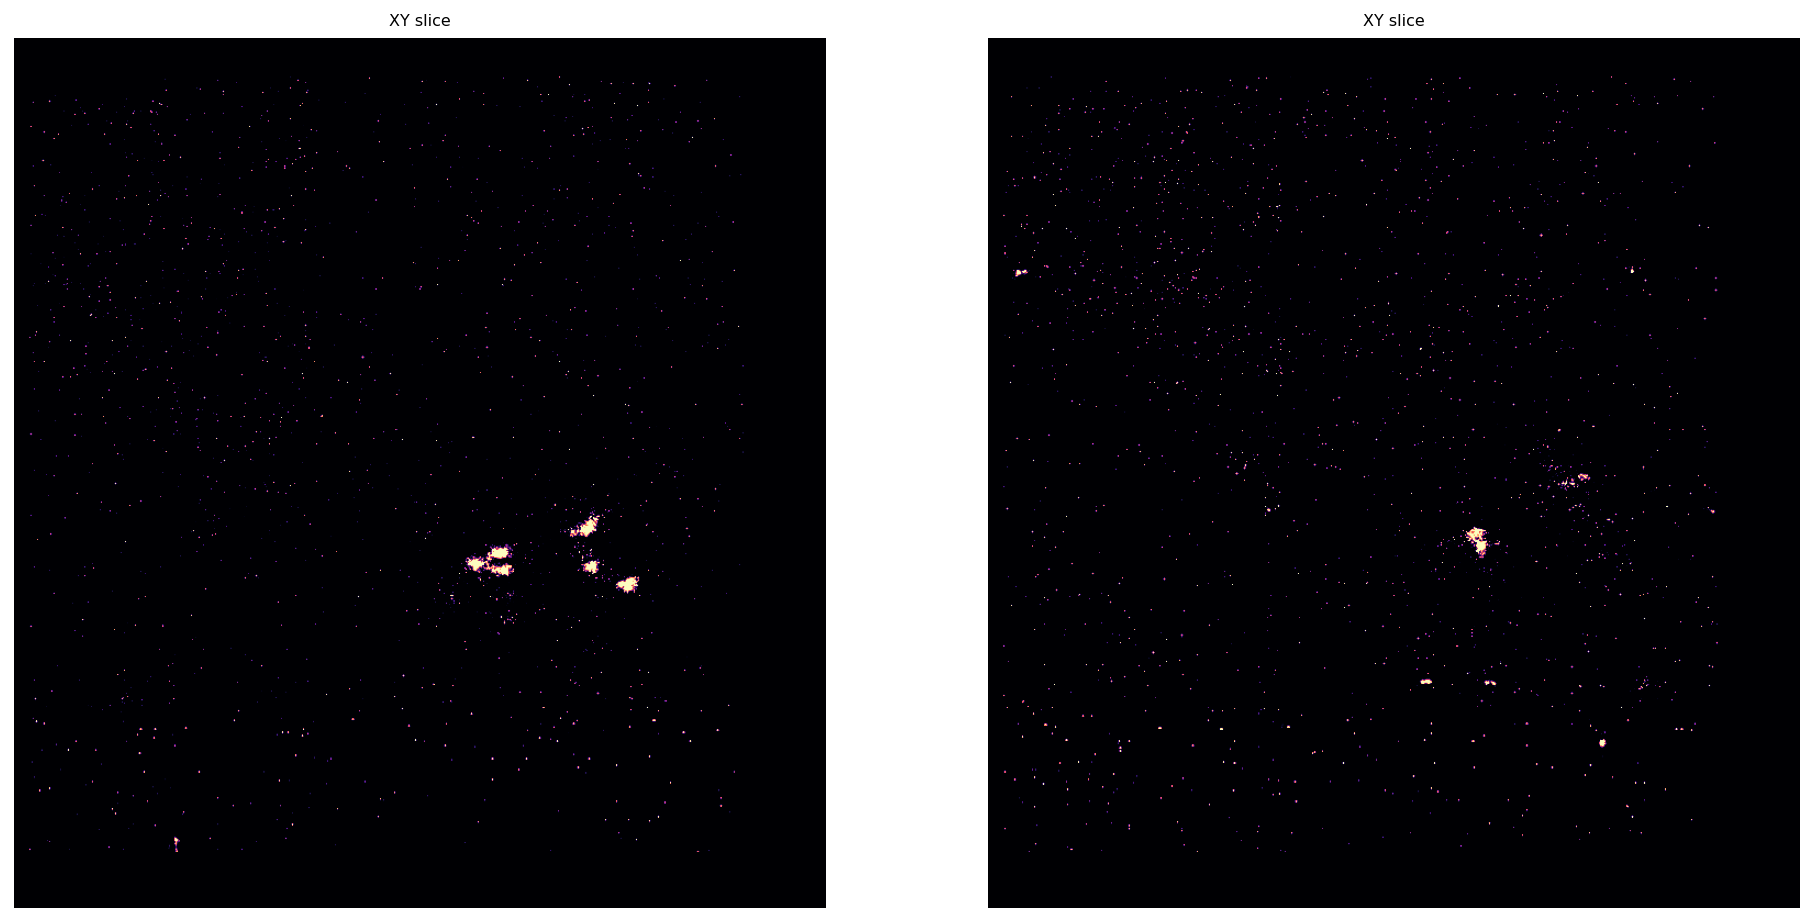

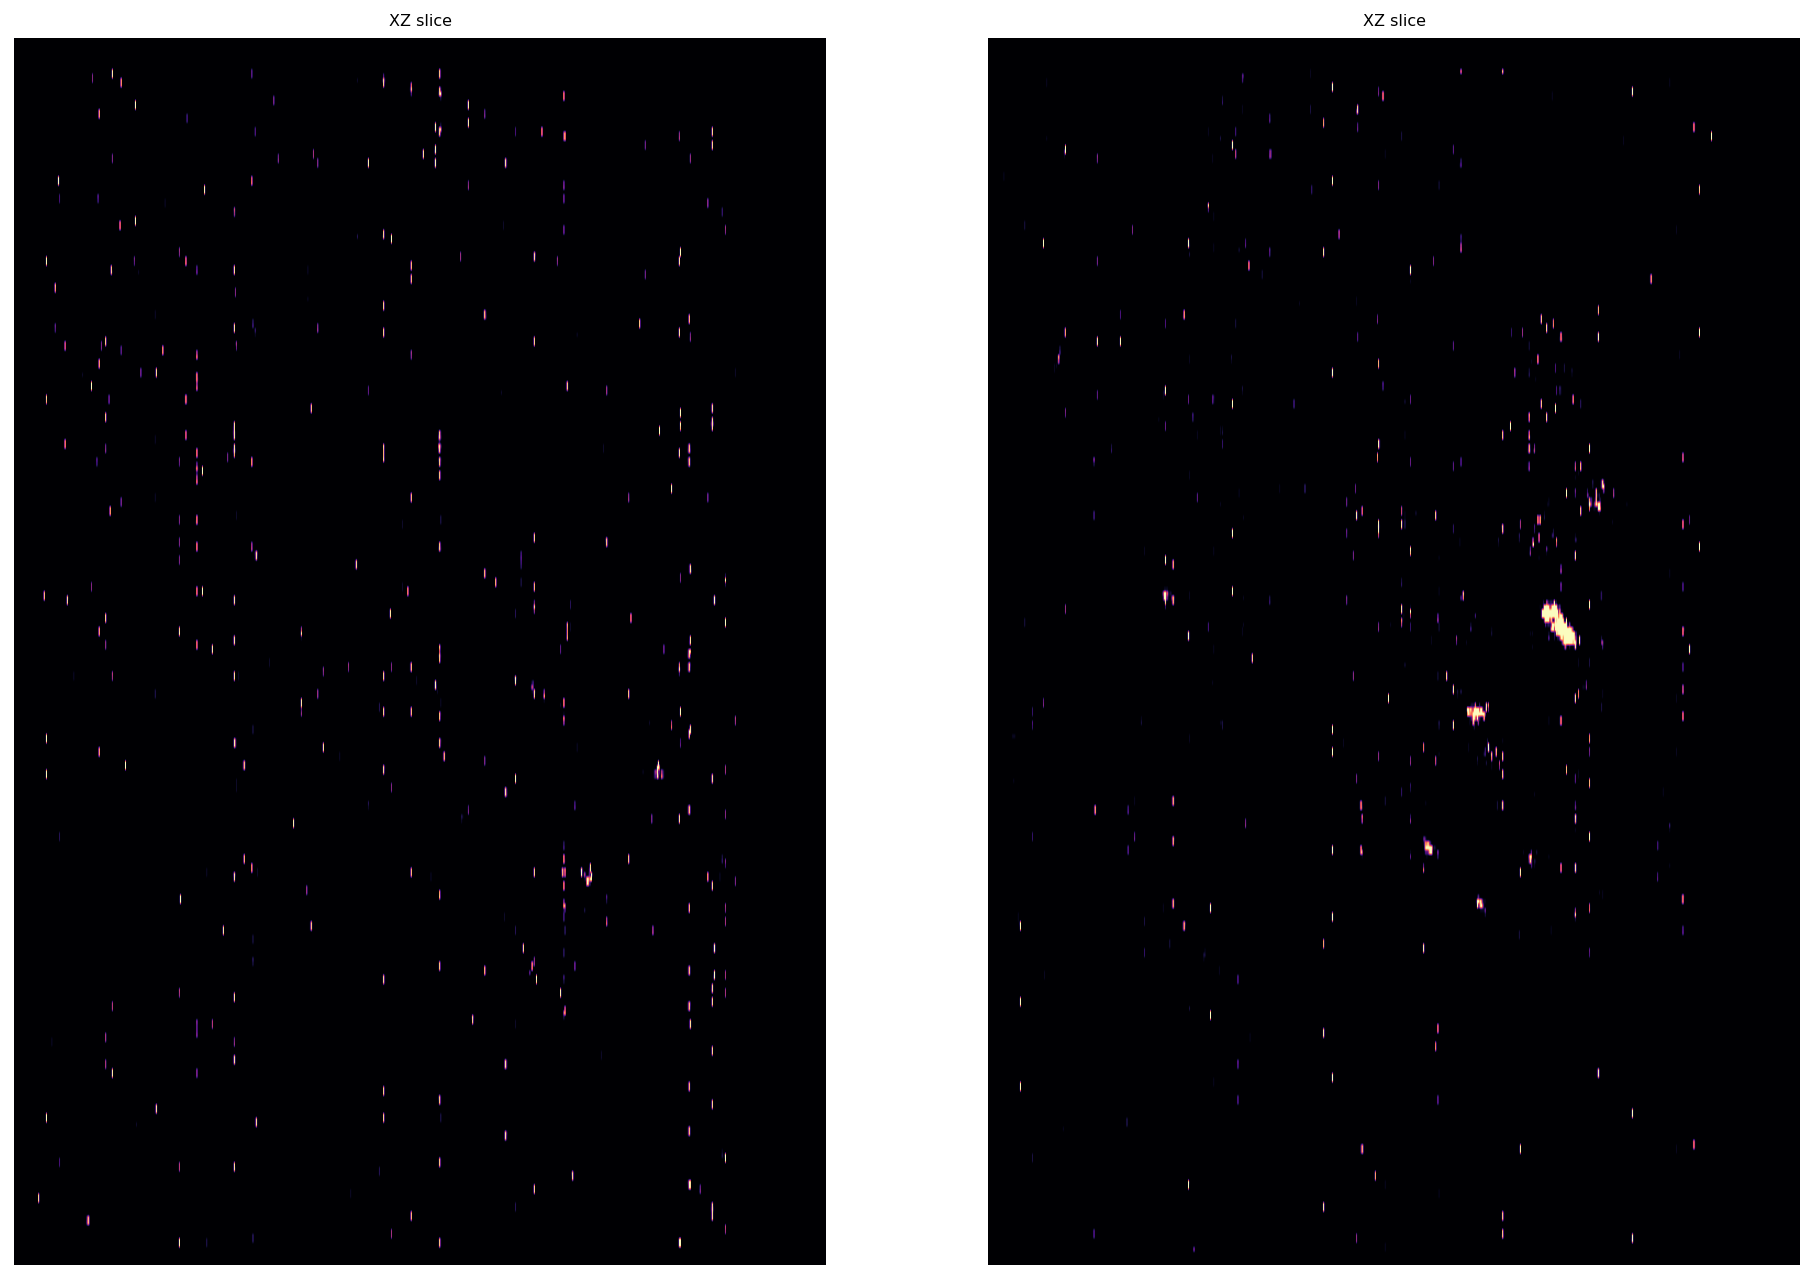

In [3]:
x = dataset.get_stack(channel, 200)
subsample = 1.97 / 0.485
print('image size         =', x.shape)
print('Z subsample factor =', subsample)

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(x, 1,-1)[[130,150]],
          title_list=[['XY slice','XY slice']],
          pmin=2,pmax=99.8);

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(np.moveaxis(x,1,-1)[:,[350,450]],1,0),
          title_list=[['XZ slice','XZ slice']],
          pmin=2,pmax=99.8, aspect=subsample);

<hr style="height:2px;">

# Generate training data for isotropic CARE

We first need to create a `RawData` object, which defines how to get pairs of images and the semantics of each axis (e.g. which one is considered a color channel, etc.).

In contrast to the standard CARE approach (e.g. [3D denoising](../denoising3D/1_datagen.ipynb)), we don't have pairs of low/high-SNR images here, just a single image.

Nevertheless, we can use `RawData.from_folder` and simply indicate the same folder as both source and target.  
We also set `axes = 'ZCYX'` to indicate the semantic order of the image axes. 

In [4]:
# time_points = {80: (95, 130), 140: (110, 150), 210: (132, 145), 210: (115, 125)}

X = []
for t in range(80, 211, 2):
    stack = np.asarray(dataset.get_stack(channel, t))
    X.append(stack)
    
    # selecing specific slices
    # for z in range(span[0], span[1] + 1):
    #     X.append(stack[z, :, :].copy())
Y = len(X) * [None]
    
raw_data = RawData.from_arrays(X, Y, axes='ZYX')

Furthermore, we must define how to modify XY slices to mimic the axial distortions of a real microscope as closely as possible. To that end, we define a `Transform` object that will take our `RawData` as input and return the modified image. Here, we use `anisotropic_distortions` to accomplish this.

The most important parameters are the subsampling factor along Z of the raw data and the PSF of the microscope that should mimic the optical abberations along Z, but now applied to the lateral X axis.

In [5]:
anisotropic_transform = anisotropic_distortions (
    subsample = subsample,
    # psf       = np.ones((3,3))/9, # use the actual PSF here
    psf = np.ones((1,1)), 
    psf_axes  = 'YX',
)

From the raw image stack and its synthetically distorted copy, we now generate corresponding patches. As a general rule, use a patch size that is a power of two along XYZT, or at least divisible by 8.  
Typically, you should use more patches the more trainings stacks you have. By default, patches are sampled from non-background regions (i.e. that are above a relative threshold), see the documentation of `create_patches` for details.

Note that returned values `(X, Y, XY_axes)` by `create_patches` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [6]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, grey_erosion

def no_background_patches_with_erosion(threshold=0.4, percentile=99.9):
    def _filter(datas, patch_size, dtype=np.float32):
        struct_elem = np.zeros((3, 3, 3), dtype=bool)
        struct_elem[1, :, :] = generate_binary_structure(2, 2)
        struct_elem[0, 1, 1] = True
        struct_elem[2, 1, 1] = True
        
        image = datas[0]
        image = grey_erosion(image, structure=struct_elem, mode='constant')
        if dtype is not None:
            image = image.astype(dtype)
            # make max filter patch_size smaller to avoid only few non-bg pixel close to image border
        patch_size = [(p//2 if p>1 else p) for p in patch_size]
        filtered = maximum_filter(image, patch_size, mode='constant')
        return filtered > threshold * np.percentile(image,percentile)
    return _filter

In [7]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (1, 128,128),
    n_patches_per_image = 512,
    transforms          = [anisotropic_transform],
    patch_filter        = no_background_patches_with_erosion(threshold=0.99, percentile=99.9)
)

   66 raw images x    1 transformations   =    66 images
   66 images     x  512 patches per image = 33792 patches in total
Input data:
numpy array
Transformations:
1 x Anisotropic distortion (along X axis)
Patch size:
1 x 128 x 128


  0%|          | 0/66 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
  2%|▏         | 1/66 [00:17<19:26, 17.94s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
  3%|▎         | 2/66 [00:35<18:53, 17.71s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
  5%|▍         | 3/66 [00:53<18:40, 17.79s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.p

 42%|████▏     | 28/66 [08:12<10:59, 17.36s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 44%|████▍     | 29/66 [08:29<10:43, 17.38s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 45%|████▌     | 30/66 [08:47<10:24, 17.34s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 47%|████▋     | 31/66 [09:04<10:05, 17.31s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data

 85%|████████▍ | 56/66 [16:19<02:53, 17.37s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 86%|████████▋ | 57/66 [16:37<02:36, 17.40s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 88%|████████▊ | 58/66 [16:54<02:18, 17.36s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data/transform.py:284: UserWarning: changing subsample from 4.061855670103093 to 4.1
  warnings.warn('changing subsample from %s to %s' % (str(_subsample),str(subsample)))
 89%|████████▉ | 59/66 [17:11<02:01, 17.30s/it]/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/data

In [8]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (33792, 1, 1, 128, 128)
axes  of X,Y = SCZYX


Since the isotropic CARE model operates on 2D (+ channel) images, we need to remove the (singleton) Z axis before saving the training data.

In [9]:
z = axes_dict(XY_axes)['Z']
X = np.take(X,0,axis=z)
Y = np.take(Y,0,axis=z)
XY_axes = XY_axes.replace('Z','')

In [10]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (33792, 1, 128, 128)
axes  of X,Y = SCYX


## Show

This shows some of the generated patch pairs (odd rows: *source*, even rows: *target*)

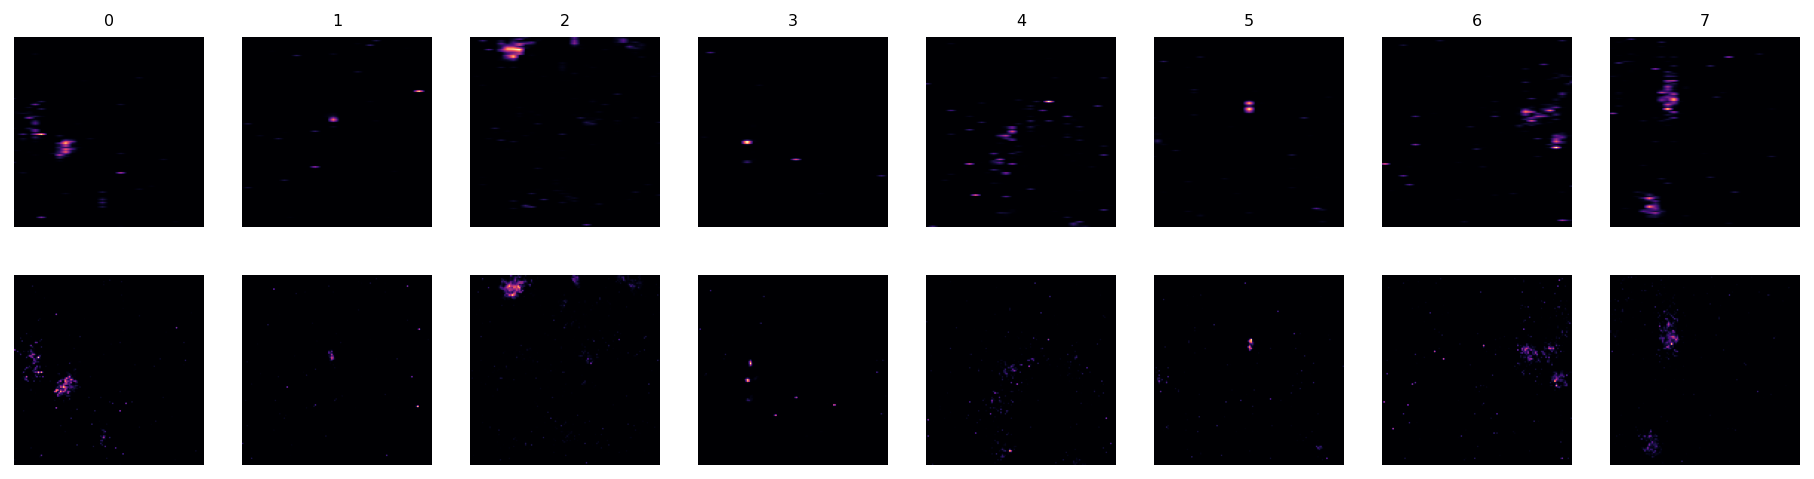

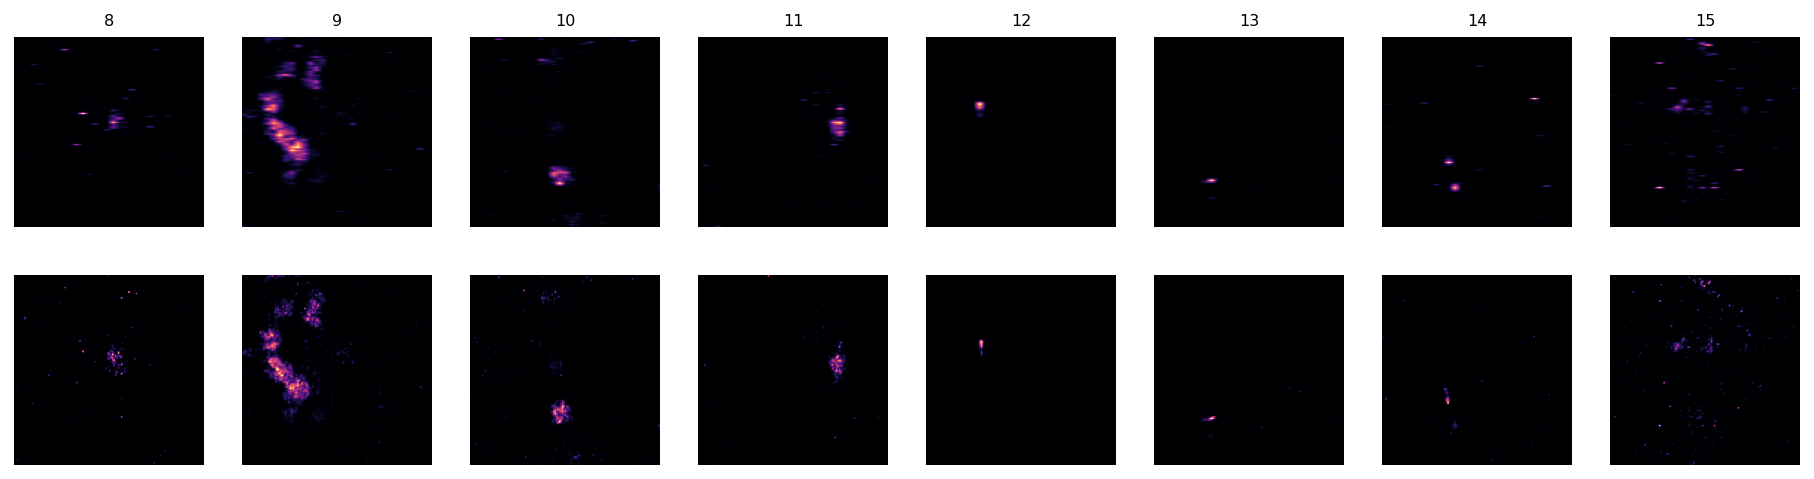

In [11]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1))
    plot_some(np.moveaxis(X[sl],1,-1),np.moveaxis(Y[sl],1,-1),title_list=[np.arange(sl.start,sl.stop)])
    plt.show()
None;

In [12]:
save_training_data('data/my_training_data_psf_1.npz', X, Y, XY_axes)